In [1]:
from random import seed
import numpy as np
import pandas as pd
import operator
from csv import reader
import math
from math import sqrt
from random import randrange
from csv import reader

In [2]:
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors, x):
    distances = list()
    p=2
    
    for train_row in train:
        #Checking if input are the various distance measures
        if x == 'euclidean':
            dist = euclidean_distance(test_row, train_row)
        elif x== 'manhattan':
            dist = manhattan_distance(test_row, train_row) 
        elif x=='minkowski':
            dist = minkowski_distance(test_row, train_row,p) 
        elif x== 'hamming':
            dist = hamming_distance(test_row, train_row)
        elif x== 'chebyshev':
            dist = chebyshev_distance(test_row, train_row)
        elif x== 'jaccard':
            dist = jaccard_distance(test_row, train_row)
        elif x== 'cosine':
            dist = cosine_similarity(test_row, train_row)
        else:
            print('error')
        distances.append((train_row, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

In [3]:
#Calculate euclidean_distance
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += pow((row1[i] - row2[i]),2)
    return sqrt(distance)

#Calculate Hamming Distance
def hamming_distance(row1,row2):
    distance = 0.0
    for i in range(len(row1)-1):
        if row1[i]!=row2[i]:
            distance += 1
    return distance 

# Calculate the Chebyshev distance between two vectors
def chebyshev_distance(row1, row2):
    distance=[]
    for i in range(len(row1)-1):
        distance.append(abs(row1[i]-row2[i]))
    return max(distance)

# Calculate the Jaccard distance between two vectors
def jaccard_distance(row1, row2):
    intersection=len(set(row1).intersection(set(row2)))
    union= len(set(row1).union(set(row2)))
    return 1-(intersection / union)

# Calculate the Manhattan distance between two vectors
def manhattan_distance(row1, row2):
    distance=0
    for i in range(len(row1)-1):
        distance += sum([abs(row1[i]-row2[i])])
    return distance
# Calculate the Minkowski distance between two vectors
def minkowski_distance(row1, row2, p): 
    distance = 0.0
    for i in range(len(row1)-1):
        distance+= abs(row1[i]-row2[i])**p
    return distance

#Calculate cosine similarity
def cosine_similarity(row1, row2):
    sumxx, sumyy, sumxy = 0, 0, 0
    for i in range(len(row1)-1):
        x = row1[i]
        y = row2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x*y
    return 1-(sumxy/(sqrt(sumxx) * sqrt(sumyy)))


In [4]:
#Read movies csv

movies = pd.read_csv('C:/Users/Admin/Desktop/movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
#Read ratings csv
rating=pd.read_csv('C:/Users/Admin/Desktop/ratings.csv',usecols=['userId', 'movieId', 'rating'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
df = movies.values


In [5]:
movies.head(5)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
rating.head()
rating=rating[:2000000]

In [7]:
# pivot ratings into movie features
movie_features = rating.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
#movie_features.head(10)


In [8]:
#number of unique users and movies
num_users = len(rating.userId.unique())
num_items = len(rating.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 20507 unique users and 26030 unique movies in this data set


In [9]:
#count users based on the rating
ratings_cnt_tmp = pd.DataFrame(rating.groupby('rating').size(), columns=['count'])
ratings_cnt_tmp

,count
rating,
0.5,37006
1.0,63892
1.5,31587
2.0,134360
2.5,96299
3.0,399042
3.5,240378
4.0,531498
4.5,169475


In [10]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - rating.shape[0]

In [11]:
ratings_cnt = ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
ratings_cnt

,count
0.0,531797210
0.5,37006
1.0,63892
1.5,31587
2.0,134360
2.5,96299
3.0,399042
3.5,240378
4.0,531498
4.5,169475


In [12]:
#log normalise to make it easier to interpret on a graph
ratings_cnt['log_count'] = np.log(ratings_cnt['count'])
ratings_cnt

,count,log_count
0.0,531797210,20.091773
0.5,37006,10.518835
1.0,63892,11.064949
1.5,31587,10.360501
2.0,134360,11.808278
2.5,96299,11.475213
3.0,399042,12.896822
3.5,240378,12.389968
4.0,531498,13.183455
4.5,169475,12.040461


Text(0, 0.5, 'number_of_ratings')

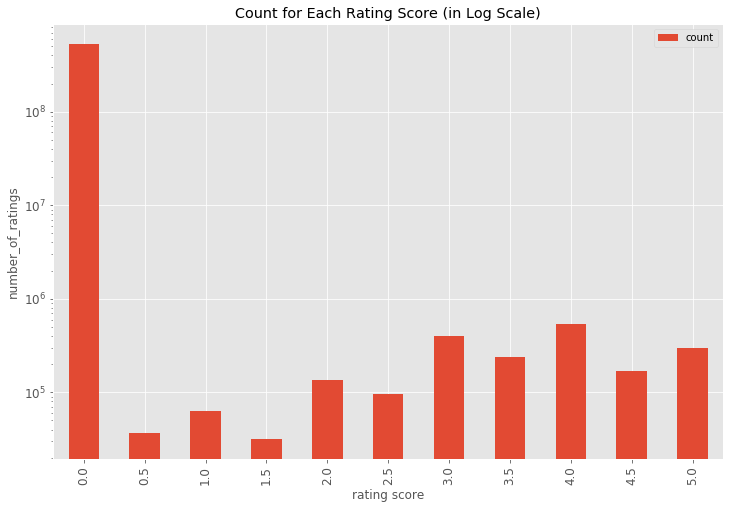

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("rating score")
ax.set_ylabel("number_of_ratings")

In [14]:
#get frequency of rating for each movie
movies_cnt = pd.DataFrame(rating.groupby('movieId').size(), columns=['count'])
movies_cnt.head()

,count
movieId,
1,4923
2,1975
3,1188
4,242
5,1138


In [15]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it
popularity_thres = 50
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = rating[rating.movieId.isin(popular_movies)]
print('shape of original ratings data: ', rating.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping unpopular movies:  (1847158, 3)


In [16]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
users_cnt.head()

,count
userId,
1,16
2,15
3,8
4,714
5,71


In [17]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', rating.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1611936, 3)


In [18]:
# pivot and create movie-user matrix
movie_user_mat = ratings_drop_users.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

In [19]:
flattened = pd.DataFrame(movie_user_mat.to_records())
final_data = flattened.values 
flattened.shape


(4802, 7758)

In [20]:
flattened.head(5)

,movieId,4,5,10,14,15,18,19,26,31,...,20484,20487,20490,20493,20497,20500,20501,20502,20503,20506
0,1,4.0,0.0,5.0,4.5,4.0,0.0,0.0,0.0,5.0,...,4.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,2,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [23]:
#Take user input of the distance measure
#Randomly select a movie and compare with neighbors based on distance
i = np.random.choice(len(final_data))
print( df[(int(final_data[i][0]) - 1)][1] + " has the following recommended movies: ")
x= input('Enter distance as "manhattan","chebyshev","minkowski","cosine",euclidean","hamming","jaccard": ')
neighbors = get_neighbors(final_data, final_data[i], 10, x)

index = list()
for y in neighbors:
    idx = int(y[0] - 1)
    index.append(idx + 1)
    print(df[idx][1])

#References:
#Dataset: https://grouplens.org/datasets/movielens/latest/
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
#https://machinelearningmastery.com/k-fold-cross-validation/
#https://en.wikipedia.org/wiki/Cosine_similarity
#https://machinelearningmastery.com/distance-measures-for-machine-learning/
#https://github.com/nikitaa30/Recommender-Systems/blob/master/knn_recommender.py
#https://aiaspirant.com/distance-similarity-measures-in-machine-learning/

Mute Witness (1994) has the following recommended movies: 
Enter distance as "manhattan","chebyshev","minkowski","cosine",euclidean","hamming","jaccard": manhattan
Mute Witness (1994)
Mad Love (1995)
Batman Forever (1995)
Wild Bill (1995)
Feast of July (1995)
Nadja (1994)
Mallrats (1995)
Castle Freak (1995)
City Hall (1996)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
